In [2]:
# cleanup
%reset -f

In [34]:
import numpy as np
import QuantLib as ql
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

In [69]:
# yield and dividends
fwdTs = ql.YieldTermStructureHandle(ql.FlatForward(settlementDate, ql.QuoteHandle(ql.SimpleQuote(0.0225)), dc))
divTs = ql.YieldTermStructureHandle(ql.FlatForward(settlementDate, ql.QuoteHandle(ql.SimpleQuote(0.02)), dc))

# static data
settlementDate = ql.Date(27, 12, 2004)
dc = ql.ActualActual()
calendar = ql.UnitedStates()
ql.Settings.instance().setEvaluationDate(settlementDate)
exerciceDate = ql.Date(28, 3, 2005)

payoff = ql.PlainVanillaPayoff(ql.Option.Call, 1.05)
exercice = ql.EuropeanExercise(exerciceDate)
opt = ql.VanillaOption(payoff, exercice)

In [64]:
# model parameters
v0 = 0.1
s0 = ql.QuoteHandle(ql.SimpleQuote(1.0))
kappa = 3.16
theta = 0.09
sigma = 0.4
rho = -0.2

process = ql.HestonProcess(rfTs, divTs, s0, v0, kappa, theta, sigma, rho)

In [65]:
# analytical engine
engine = ql.AnalyticHestonEngine(ql.HestonModel(process), 64)
opt.setPricingEngine(engine)

# test vs cached values
expected = 0.0404774515;
analytical = opt.NPV()
tol = 10e-6

print("analytical engine valuation: " + str(val))
if(abs(expected - analytical) < tol):
    print ("success")
else:
    print("failed")

analytical engine valuation: 0.04047745149137455
success


In [66]:
# fd engine
engine = ql.FdHestonVanillaEngine(ql.HestonModel(process), 200, 400, 200)
opt.setPricingEngine(engine)

# test vs cached values
expected = 0.0404774515;
fdDefault = opt.NPV()
tol = 10e-6

print("default fdm valuation: " + str(fdDefault))
if(abs(expected - fdDefault) < tol):
    print ("success")
else:
    print("failed")

default fdm valuation: 0.04047839106046903
success


In [67]:
# compare comvergence for different fd schemes
models = { \
    'Douglas'             : ql.FdmSchemeDesc.Douglas(),
    'CraigSneyd'          : ql.FdmSchemeDesc.CraigSneyd(),
    'ModifiedCraigSneyd'  : ql.FdmSchemeDesc.ModifiedCraigSneyd(),
    'Hundsdorfer'         : ql.FdmSchemeDesc.Hundsdorfer(),
    'ModifiedHundsdorfer' : ql.FdmSchemeDesc.ModifiedHundsdorfer(),
    #'ExplicitEuler'       : ql.FdmSchemeDesc.ExplicitEuler(), # does not converge for this model
    'ImplicitEuler'       : ql.FdmSchemeDesc.ImplicitEuler()
         }

steps = [10, 25, 50, 75, 100, 125, 150, 175, 200]

# utility function
def hlp(opt, x, method):
    engine = ql.FdHestonVanillaEngine(ql.HestonModel(process), x, 2 * x, x, 0, method)
    opt.setPricingEngine(engine)
    return opt.NPV()

results = {}
for i in models:
    try:
        results[i] = list(map(lambda x: hlp(opt, x, models[i]), steps))
    except:
        pass

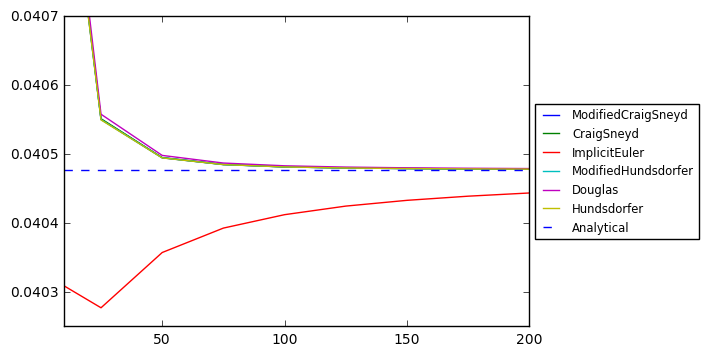

In [68]:
for i in models:
    plt.plot(steps, results[i], label = i)
    
plt.xlim([10, 200])
plt.ylim([0.04025, 0.0407])
plt.axhline(y = analytical, xmin = 0, xmax = 200, label = 'Analytical', linestyle = '--')
fontP = FontProperties()
fontP.set_size('small')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop = fontP)
plt.show()

In [101]:
# plot the smile
strikes = np.arange(0.8, 1.25, 0.05)
payoffs = map(lambda x: ql.PlainVanillaPayoff(ql.Option.Call, x), strikes)
opts = list(map(lambda x: ql.VanillaOption(x, exercice), payoffs))

engine = ql.FdHestonVanillaEngine(ql.HestonModel(process), 100, 200, 100, 0,
                                  ql.FdmSchemeDesc.Hundsdorfer())

for i in opts:
    i.setPricingEngine(engine)
    
res = list(map(lambda x: x.NPV(), opts))
print(res)

[0.20499622906762383, 0.16137432168175728, 0.1220952048985772, 0.08844275384949335, 0.061211833025201216, 0.04048152786176675, 0.025637349027388925, 0.015608652144289935, 0.009181027836442715]
